Atividade 5: Realizar uma pré-distorção
a. Partindo dos resultados da Atividade 3, o PA a ser linearizado é um modelo MP (ou seja, seu PA será o modelo MP treinado na Atividade 3). 
b. Treinar um DPD. Como modelo de DPD, usar o MP (ou seja, PA e DPD terão a mesma equação, porém coeficientes diferentes). Para treinar o DPD, primeiro coletar dados na entrada e na saída do MP que modelo o PA (ou seja, passar o in_extraction no MP e medir a saída estimada). No DPD, trocam-se os papeís de entrada e saída (ou seja, saída do PA é entrada do DPD e vice-versa)
c. Obter a seguinte cascata (modelo MP do DPD +  modelo MP do PA):
c1. O sinal de entrada, a ser aplicado no modelo MP do DPD  treinado no item b. é ganho*in_validation. O ganho é um número fixo e evita extrapolação do modelo. Obtê-lo usando ganho= abs(out_esimado_PA)/abs(in).  
c2. O sinal estimado na saída do modelo MP do DPD  agora deve ser aplicado como entrada do modelo MP do PA. 
d. Para validar a pré-distorção, comparar a entrada da cascata com a saída da cascata.


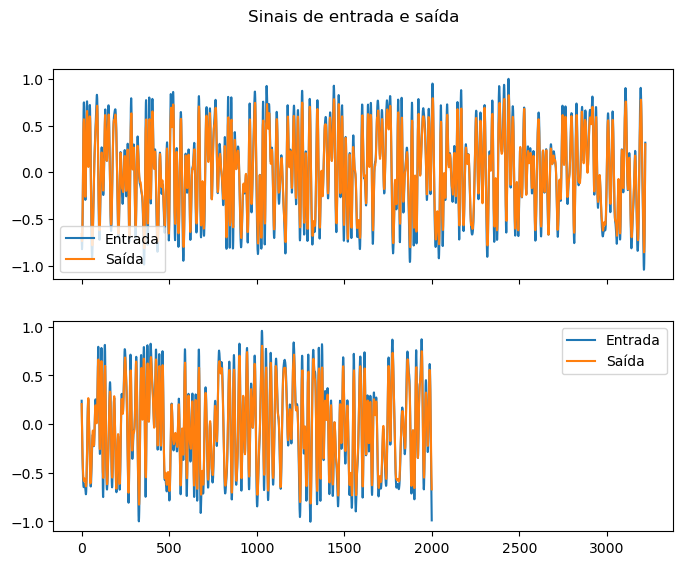

In [1]:
from functions import *

mat = loadmat('in_out_SBRT2_direto.mat')

in_data_ext = mat['in_extraction']
out_data_ext = mat['out_extraction']
in_data_val = mat['in_validation']
out_data_val = mat['out_validation']


lista = [in_data_ext, out_data_ext, in_data_val, out_data_val]

modulos = []
for i in lista:
    modulos.append(max(i.imag))
    modulos.append(max(i.real))

maior_modulo = max(modulos)

in_ext_norm  = in_data_ext / maior_modulo
out_ext_norm = out_data_ext /maior_modulo
in_val_norm  = in_data_val/maior_modulo
out_val_norm = out_data_val/maior_modulo

plot_signals(in_ext_norm,out_ext_norm, in_val_norm,out_val_norm)

In [2]:
M = 3
P = 5

# calculo dos coeficientes do modelo do PA
XX_ext_PA, coefficients_PA_float = extract_coefficients(in_data_ext,out_data_ext,M, P)
# Saida estimada do modelo do PA
predicted_ext_PA = XX_ext_PA @ coefficients_PA_float

# Calculo do modelo do pre-distorcedor
XX_ext_pre, coefficients_DPD_float = extract_coefficients(predicted_ext_PA,in_data_ext, M, P)
# Saida estimada do modelo do predistorcedor
predicted_ext_pre = XX_ext_pre @ coefficients_DPD_float

# saida estimada da cascata
XX_val_PA = mp(P, M, in_data_val)
predicted_val_PA = XX_val_PA @ coefficients_DPD_float

XX_val_DPD = mp(P, M, predicted_val_PA)
predicted_val_DPD = XX_val_DPD @ coefficients_PA_float

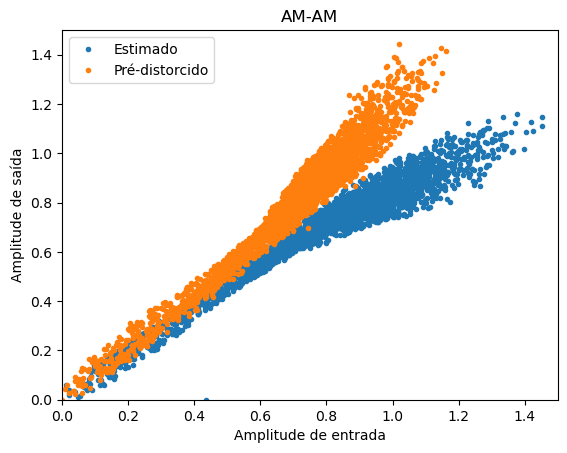

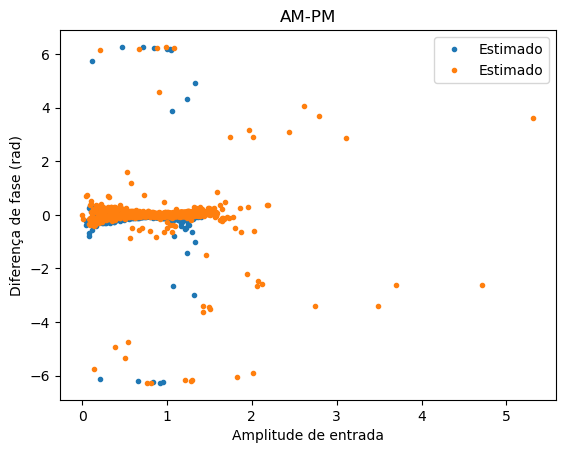

In [3]:
# Gráficos AM-AM e AM-PM
plt.figure()
# plt.plot(np.abs(in_val_fixed[M:]), np.abs(out_val_fixed[M:]), '.', label='Medido')
plt.plot(np.abs(in_data_ext[M:]), np.abs(predicted_ext_PA), '.', label='Estimado')
plt.plot(np.abs(predicted_ext_PA[M:]), np.abs(predicted_ext_pre), '.', label='Pré-distorcido')
# plt.plot(np.abs(in_data_val[M*2:]), np.abs(predicted_val_pre_2), '.', label='Saida'  )
plt.xlim([0, 1.5])
plt.ylim([0, 1.5])

plt.xlabel('Amplitude de entrada')
plt.ylabel('Amplitude de saída')
plt.title('AM-AM')
plt.legend()

plt.figure()
# plt.plot(np.abs(in_val_fixeMd[M:]), np.angle(out_val_fixed[M:])-np.angle(in_val_fixed[M:]), '.', label='Medido')
plt.plot(np.abs(in_data_val[M:]), np.angle(predicted_val_PA)-np.angle(in_data_val[M:]), '.', label='Estimado')
plt.plot(np.abs(predicted_val_PA[M:]), np.angle(predicted_val_DPD)-np.angle(predicted_val_PA[M:]), '.', label='Estimado')
plt.xlabel('Amplitude de entrada')
plt.ylabel('Diferença de fase (rad)')
plt.title('AM-PM')
plt.legend()
plt.show()

In [4]:
XX_ext_pa = mp(P, M, in_ext_norm)
coefficients_norm_pa, _, _, _ = np.linalg.lstsq(XX_ext_pa, out_ext_norm[M:], rcond=None)


# Calculo dos coeficientes do modelo do pre-distorcedor
XX_ext_pre = mp(P, M, predicted_ext_PA)
coefficients_norm_pre, _, _, _ = np.linalg.lstsq(XX_ext_pre , in_ext_norm[M*2:], rcond=None)

C:\Users\Je\AppData\Local\Temp\ipykernel_15284\603511062.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


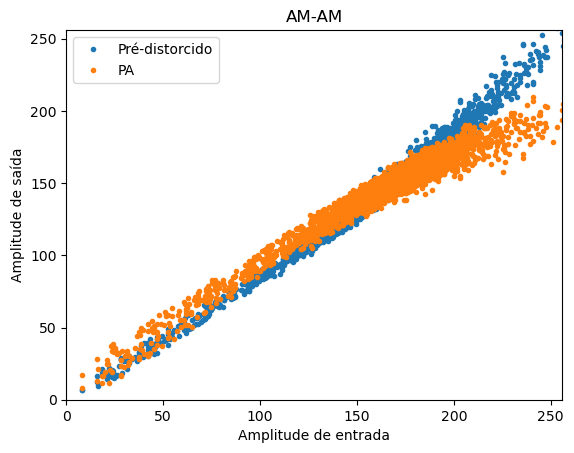

In [5]:
M = 1
P = 2
p_bits = 8
# normalização
in_val_fixed = np.round(in_val_norm * (2 ** p_bits)) 
out_val_fixed = np.round(out_val_norm * (2 ** p_bits))
in_ext_fixed = np.round(in_ext_norm * (2 ** p_bits)) 
out_ext_fixed = np.round(out_ext_norm * (2 ** p_bits))

# calculo dos coeficientes do modelo do PA
predicted_val_ext = XX_ext_pa @ coefficients_norm_pa

# modelo do PA
XX_val_PA = mp_int(P, M, in_val_fixed, p_bits)
predicted_val_fixed_PA, e_bits = MultiplicadorMatrizes(coefficients_norm_pa, XX_val_PA, p_bits)

# modelo do predistocedor
XX_val_pre = mp_int(P, M, in_val_fixed, p_bits)
predicted_val_fixed_pre, e_bits = MultiplicadorMatrizes(coefficients_norm_pre, XX_val_pre, p_bits)

fig, ax = plt.subplots()
ax.plot(np.abs(in_val_fixed[M:]), np.abs(predicted_val_fixed_pre), '.', label='Pré-distorcido')
ax.plot(np.abs(in_val_fixed[M:]), np.abs(predicted_val_fixed_PA), '.', label='PA')
ax.set_xlim([0, 2 ** p_bits])
ax.set_ylim([0, 2 ** p_bits])

ax.set_xlabel('Amplitude de entrada')
ax.set_ylabel('Amplitude de saída')
ax.set_title('AM-AM')
ax.legend()
fig.show()

In [6]:
init_msg = '''
onerror {resume}
quietly WaveActivateNextPane {} 0
add wave -noupdate /dpd/reset
add wave -noupdate /dpd/clk
add wave -noupdate /dpd/UR
add wave -noupdate /dpd/UI
add wave -noupdate /dpd/UR_out
add wave -noupdate /dpd/UI_out
add wave -noupdate /dpd/U_signal_out
add wave -noupdate /dpd/U_signal_in
add wave -noupdate /dpd/power_matrix
add wave -noupdate /dpd/confusion_matrix
add wave -noupdate /dpd/multiplic
add wave -noupdate /dpd/sum
TreeUpdate [SetDefaultTree]
WaveRestoreCursors {{Cursor 1} {0 ps} 0}
quietly wave cursor active 0
configure wave -namecolwidth 150
configure wave -valuecolwidth 100
configure wave -justifyvalue left
configure wave -signalnamewidth 0
configure wave -snapdistance 10
configure wave -datasetprefix 0
configure wave -rowmargin 4
configure wave -childrowmargin 2
configure wave -gridoffset 0
configure wave -gridperiod 1
configure wave -griddelta 40
configure wave -timeline 0
configure wave -timelineunits ps
update
WaveRestoreZoom {0 ps} {1 ns}

force -freeze sim:/dpd/reset 1 0
force -freeze sim:/dpd/UR 000000000 0
force -freeze sim:/dpd/UI 000000000 0
force -freeze sim:/dpd/clk 1 0, 0 {50 ps} -r 100
run 200 ps
force -freeze sim:/dpd/reset 0 0
run 100 ps
'''

data_value = '''
run 100 ps
force -freeze sim:/dpd/UR {val_rel} 0
force -freeze sim:/dpd/UI {val_imag} 0'''

inteiro_para_binario = lambda numero, pbits: bin(numero & ((1 << pbits) - 1))[2:].zfill(pbits + 1)


message = init_msg
for value in predicted_val_fixed_pre[:50]:
    message += data_value.format(val_rel = inteiro_para_binario(int(value.real[0]), p_bits),val_imag = inteiro_para_binario(int(value.imag[0]), p_bits))

with open('VHDL/macro.do', 'w') as file_do:
    file_do.write(message)


In [7]:
predicted_val_fixed_pre

array([[  36.+139.j],
       [   5.+138.j],
       [ -21.+131.j],
       ...,
       [-183. +32.j],
       [-235. +32.j],
       [   0.  +0.j]])